In [2]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests


from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs


# Import csv from Hongjie

In [3]:
SOCATstd = pd.read_csv('/Users/akbaskind/Documents/MATLAB/SOCAT/VAR_SOCAT_NanStd.csv')

In [4]:
SOCATstd.where(SOCATstd['minYr'] == 1962).dropna()

,lon,lat,minYr,maxYr,UniqueYrs,StdfCO2,StdpH,StdOmegaAr,StdfCO2_detrended,StdpH_detrended,StdOmegaAr_detrended,dist_to_land
401,136.0,25.0,1962.0,2021.0,39.0,40.328,0.039001,0.15231,32.998,0.035255,0.13356,79.0
402,136.0,26.0,1962.0,2021.0,37.0,43.973,0.046154,0.15474,36.169,0.039462,0.14448,79.0
439,137.0,26.0,1962.0,2021.0,43.0,40.258,0.040750,0.16543,34.440,0.037481,0.15634,79.0


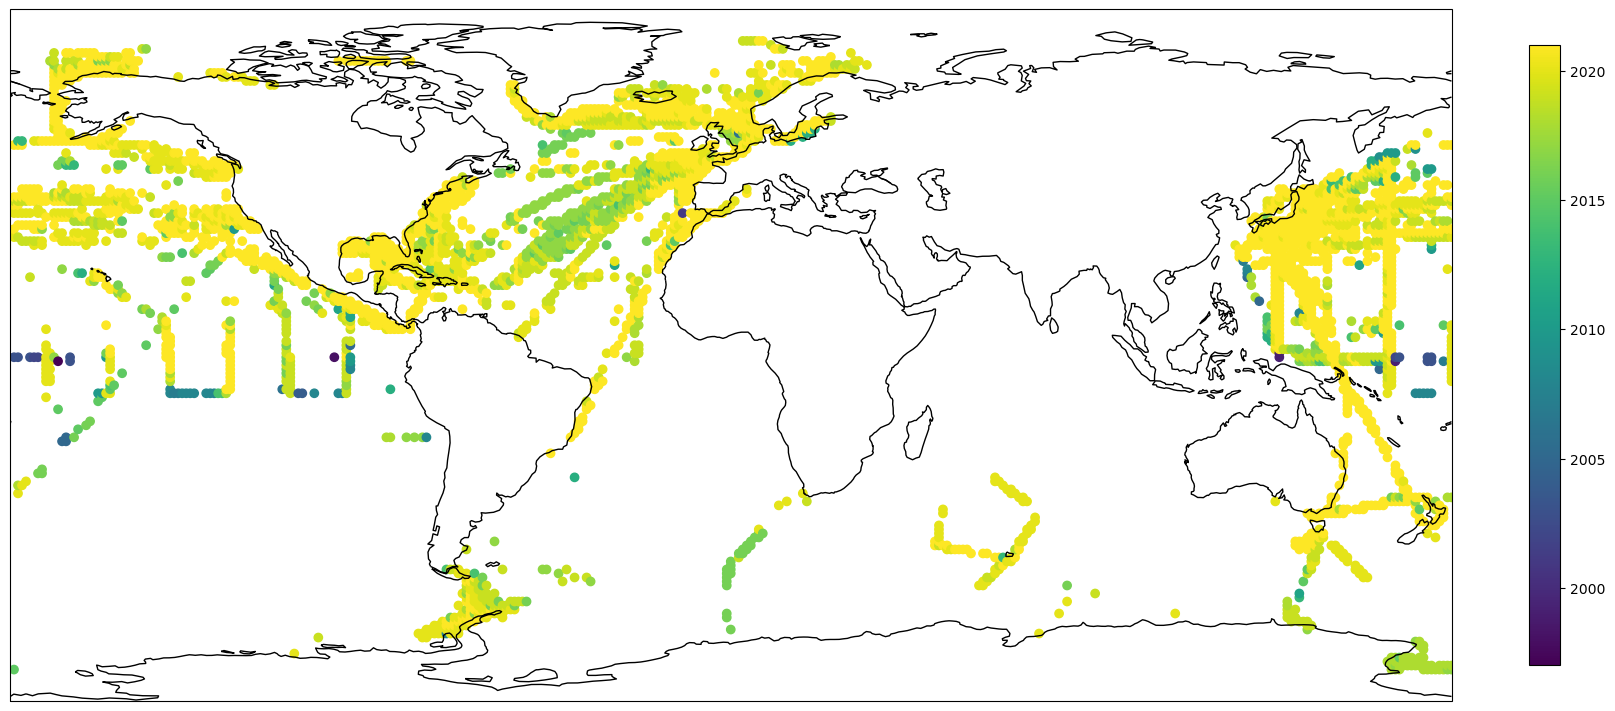

In [5]:
fig, ax = plt.subplots(figsize=[20,20], subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
im = ax.scatter(SOCATstd['lon'], SOCATstd['lat'], c = SOCATstd['maxYr'])
cbar = plt.colorbar(im, ax= ax, fraction = 0.02)

In [6]:
SOCATstd['minYr'].mean()

1995.7563134600364

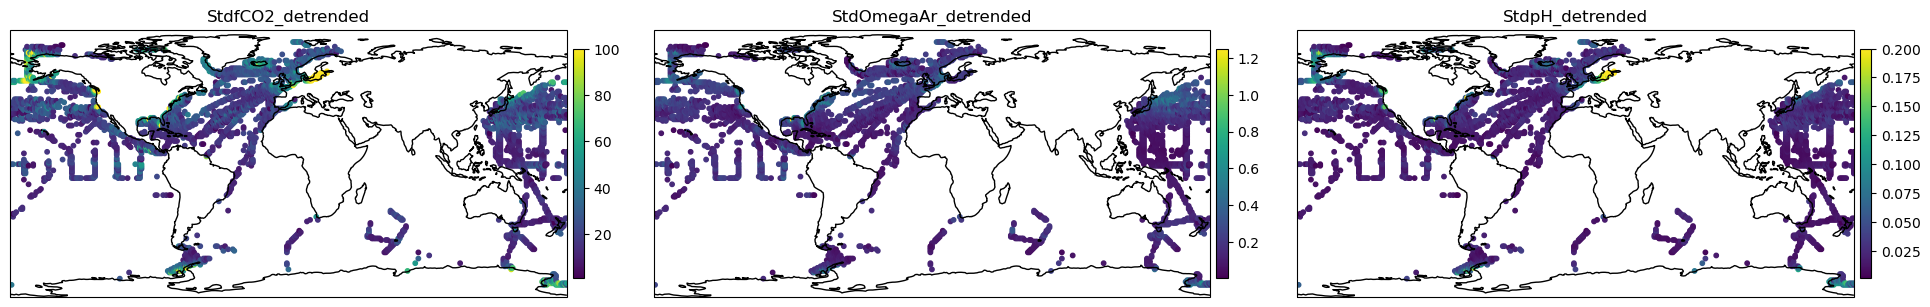

In [40]:
fig, axarr = plt.subplots(ncols = 3, figsize=[20,20], subplot_kw={'projection':ccrs.PlateCarree()})
fig.tight_layout(pad = 5)

ax_idx = 0 # index for your axes array
num = [0,1,2]
for i in num:
    ax = axarr.flat[ax_idx]
    ax.coastlines()
    if ax_idx == 0:
        Z = SOCATstd['StdfCO2_detrended']
        VMAX = 100
        title = 'StdfCO2_detrended'
    elif ax_idx == 1:
        Z = SOCATstd['StdOmegaAr_detrended']
        VMAX = 1.25
        title = 'StdOmegaAr_detrended'
    elif ax_idx == 2:
        Z = SOCATstd['StdpH_detrended']
        VMAX = 0.2
        title = 'StdpH_detrended'
    im = ax.scatter(SOCATstd['lon'], SOCATstd['lat'], c = Z, s = 10, vmax = VMAX)
    cbar = plt.colorbar(im,ax = ax, orientation='vertical',fraction = 0.02, pad=0.01)
    ax.set_title(title)
    
    ax_idx += 1

# Reformat SOCAT data to resemble model data structure

In [7]:
SOCATstd

,lon,lat,minYr,maxYr,UniqueYrs,StdfCO2,StdpH,StdOmegaAr,StdfCO2_detrended,StdpH_detrended,StdOmegaAr_detrended,dist_to_land
0,0,-68,1996,2016,12,36.740,0.040777,0.138880,35.507,0.039622,0.134860,80
1,0,-54,1998,2016,11,14.435,0.015113,0.065906,12.662,0.013230,0.066775,80
2,0,-53,1996,2016,12,13.782,0.014545,0.073006,11.130,0.012140,0.078753,80
3,0,-52,1998,2016,12,15.027,0.016208,0.083447,13.747,0.014991,0.085889,80
4,0,-51,1998,2016,11,14.141,0.015745,0.098127,12.685,0.014137,0.092334,80
...,...,...,...,...,...,...,...,...,...,...,...,...
3836,359,58,2001,2021,19,32.240,0.028283,0.179710,33.138,0.031184,0.169320,42
3837,359,59,2001,2021,19,44.452,0.049066,0.283610,43.703,0.048722,0.284650,42
3838,359,60,2001,2021,16,25.269,0.026742,0.159170,25.142,0.026914,0.160020,42
3839,359,65,2005,2020,9,43.004,0.052813,0.374930,41.707,0.051635,0.372410,42


In [8]:
dd = xr.Dataset()
dd = dd.assign_coords({'lat': np.arange(-89.5,90,1), 'lon': np.arange(0.5,360,1)})
dat = np.zeros((len(dd.lat), len(dd.lon)))
dat[:] = np.nan
dd['StdpH'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['minYr'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['maxYr'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['UniqueYrs'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdfCO2'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdOmegaAr'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdpH_detrended'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdfCO2_detrended'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdOmegaAr_detrended'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd

<xarray.Dataset>
Dimensions:               (lat: 180, lon: 360)
Coordinates:
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    StdpH                 (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    minYr                 (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    maxYr                 (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    UniqueYrs             (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    StdfCO2               (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    StdOmegaAr            (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    StdpH_detrended       (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    StdfCO2_detrended     (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    StdOmegaAr_detrended  (lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [9]:
for i in np.arange(-90,90,1):
    for j in np.arange(0,360,1):
        # dd.lat.values:
        a = SOCATstd.where(SOCATstd['lon'] == j).where(SOCATstd['lat'] == i).dropna()
        if a.size > 0:
            dd["minYr"] = xr.where((dd.coords["lat"] == i + 0.5) & (dd.coords["lon"] == j + 0.5), a['minYr'].values[0], dd["minYr"])
            dd["maxYr"] = xr.where((dd.coords["lat"] == i + 0.5) & (dd.coords["lon"] == j + 0.5), a['maxYr'].values[0], dd["maxYr"])
            dd["UniqueYrs"] = xr.where((dd.coords["lat"] == i + 0.5) & (dd.coords["lon"] == j + 0.5), a['UniqueYrs'].values[0], dd["UniqueYrs"])
            dd["StdpH"] = xr.where((dd.coords["lat"] == i + 0.5) & (dd.coords["lon"] == j + 0.5), a['StdpH'].values[0], dd["StdpH"])
            dd["StdfCO2"] = xr.where((dd.coords["lat"] == i + 0.5) & (dd.coords["lon"] == j + 0.5), a['StdfCO2'].values[0], dd["StdfCO2"])
            dd["StdOmegaAr"] = xr.where((dd.coords["lat"] == i + 0.5) & (dd.coords["lon"] == j + 0.5), a['StdOmegaAr'].values[0], dd["StdOmegaAr"])
            dd["StdpH_detrended"] = xr.where((dd.coords["lat"] == i + 0.5) & (dd.coords["lon"] == j + 0.5), a['StdpH_detrended'].values[0], dd["StdpH_detrended"])
            dd["StdfCO2_detrended"] = xr.where((dd.coords["lat"] == i + 0.5) & (dd.coords["lon"] == j + 0.5), a['StdfCO2_detrended'].values[0], dd["StdfCO2_detrended"])
            dd["StdOmegaAr_detrended"] = xr.where((dd.coords["lat"] == i + 0.5) & (dd.coords["lon"] == j + 0.5), a['StdOmegaAr_detrended'].values[0], dd["StdOmegaAr_detrended"])

In [10]:
dd.to_netcdf('/Users/akbaskind/Documents/Python Scripts/YoE/SOCAT_akb.nc')

In [376]:
# a = SOCATstd.where(SOCATstd['lon'] == 320).where(SOCATstd['lat'] == 35).dropna()
dd["minYr"] = xr.where((dd.coords["lat"] == 35) & (dd.coords["lon"] == 320), 1000, dd["minYr"])
dd.minYr.loc[35,320]

<xarray.DataArray 'minYr' ()>
array(1000.)
Coordinates:
    lat      int64 35
    lon      int64 320

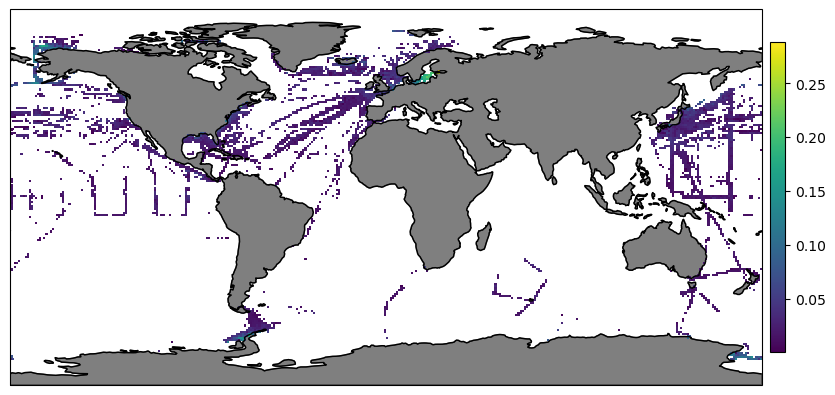

In [427]:
fig, ax = plt.subplots(figsize=[10,10],subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, color = 'black', alpha = 0.5)
x,y = np.meshgrid(dd.StdpH.lon, dd.StdpH.lat)
im = ax.pcolormesh(dd.lon, dd.lat, dd['StdpH'])
plt.colorbar(im,ax = ax, orientation='vertical',fraction = 0.02, pad=0.01)


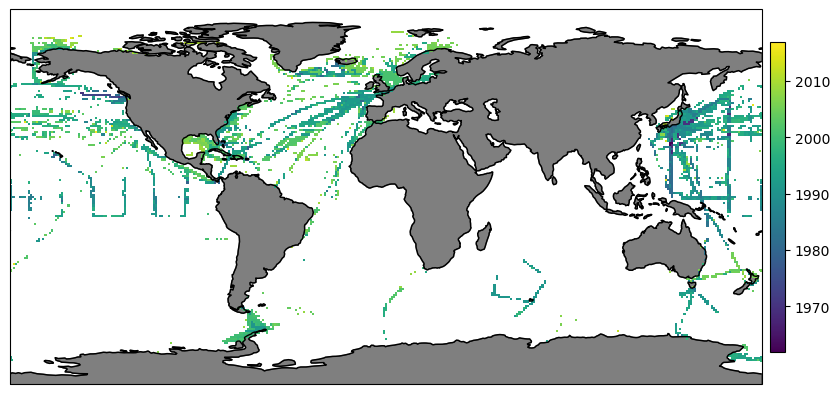

In [401]:
fig, ax = plt.subplots(figsize=[10,10],subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, color = 'black', alpha = 0.5)
x,y = np.meshgrid(dd.minYr.lon, dd.StdpH.lat)
im = ax.pcolormesh(dd.lon, dd.lat, dd['minYr'])
plt.colorbar(im,ax = ax, orientation='vertical',fraction = 0.02, pad=0.01)
